###80.ID番号への変換

問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．


---
这个问题里边创建了一个辞典word2id，词典内保存了训练集train中每一种单词和其对应的id（index）

In [ ]:
import pandas as pd
from collections import defaultdict
import string

train=pd.read_table("/content/drive/MyDrive/Colab Notebooks/chapter09/_train.txt",sep='\t',header=0,names=['TITLE','CATEGORY'])
valid=pd.read_table("/content/drive/MyDrive/Colab Notebooks/chapter09/_valid.txt",sep='\t',header=0,names=['TITLE','CATEGORY'])
test=pd.read_table("/content/drive/MyDrive/Colab Notebooks/chapter09/_test.txt",sep='\t',header=0,names=['TITLE','CATEGORY'])

dic=defaultdict(int)
#remove the punctuation in the title
table=str.maketrans(string.punctuation,' '*len(string.punctuation))
for text in train['TITLE']:
  for word in text.translate(table).split():
    dic[word]+=1

dic=sorted(dic.items(),key=lambda x:x[1],reverse=True)

word2id=defaultdict(int)
for i,(word,cnt) in enumerate(dic):
  if cnt>1 and word not in word2id:
    word2id[word]=1+i

print(len(word2id))
#word2id



9377


---
tokenizer函数：接收一个字符串，将字符串的单词转换为word2id内对应的id，返回对应的
id列

In [ ]:
'''
@para
text
word2id
unk=0: when find a unknown word, give it 0 as id
'''
def tokenizer(text,word2id=word2id,unk=0):
  #remove the punctuation in the text
  table=str.maketrans(string.punctuation,' '*len(string.punctuation))
  ids=[]
  for word in text.translate(table).split():
    #dict.get(key,[default]): if key not in dict, return default
    ids.append(word2id.get(word,unk))
  return ids

---
测试一下tokenizer

In [ ]:
text = "Fitch Lowers South abcd Credit-Rating Outlook to Negative"
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Fitch Lowers South abcd Credit-Rating Outlook to Negative
ID列: [190, 5180, 445, 0, 298, 2645, 221, 1, 1333]


###81.RNNによる予測


---
搞一个RNN模型，输入一句话（单词列），输出这句话的分类。

设定RNN的三个层：输入层(emb)、隐藏层(rnn)、输出层(fc，这层用的线性变化)。

* nn.Embedding 输入单词ID和one-hot vector，返回指定size的一个词向量

* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding

* nn.RNN 

* https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN



In [ ]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    #input layer
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    #hidden layer
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    #  
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden() 
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size)
    return hidden

---
这块儿搞一个类，把之前raw的训练集啥的给整成全都是index的样子。
具体这个类保存了数据集里面的title和category，并且把title的单词给换成index，然后把category换成数字0123。原来的title叫inputs，category叫labels

In [ ]:
from torch.utils.data import Dataset

'''
This dataset stores a tensor of the ids of the words called inputs, and the labels of inputs

'''

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.y)

  #define the return value of dataset[index]
  def __getitem__(self, index):
    #text = [index]th TITLE sentence in the dataset
    text = self.X[index]
    #inputs =ids of each word in the text
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

---
创建好的数据集里面大概长这样

In [ ]:
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}

y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

dataset_train[10]['inputs']


tensor([ 351,  399,  318, 1888,    1,    7,  449,    4,  742,  174, 1237])

---
拿一个模型出来跑跑看。

参数设置：


*   VOCAB_SIZE:输入单词的种类数，+1的是用来padding的id
*   EMB_SIZE:给他转换成embedding的时候的size，300的话embedding就是（300，1）的size
*  PADDING_INDEX：
* OUTPUT_SIZE:那肯定就是有多少种类别就输出多大的embedding，表示这句话属于每个类别的概率
* HIDDEN_SIZE:隐藏层的size喽



In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1  # number of ids in dict + padding id
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# define an RNN model
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(X.size())
  print(X.unsqueeze(0).size())
  print(model(X.unsqueeze(0)).size())
  print(torch.softmax(model(X.unsqueeze(0)),dim=-1))

torch.Size([9])
torch.Size([1, 9])
torch.Size([1, 4])
tensor([[0.3144, 0.2074, 0.1785, 0.2997]], grad_fn=<SoftmaxBackward>)
torch.Size([10])
torch.Size([1, 10])
torch.Size([1, 4])
tensor([[0.1742, 0.2083, 0.2964, 0.3211]], grad_fn=<SoftmaxBackward>)
torch.Size([10])
torch.Size([1, 10])
torch.Size([1, 4])
tensor([[0.2047, 0.2344, 0.2876, 0.2733]], grad_fn=<SoftmaxBackward>)
torch.Size([14])
torch.Size([1, 14])
torch.Size([1, 4])
tensor([[0.2099, 0.1790, 0.2479, 0.3632]], grad_fn=<SoftmaxBackward>)
torch.Size([14])
torch.Size([1, 14])
torch.Size([1, 4])
tensor([[0.3428, 0.2126, 0.1946, 0.2500]], grad_fn=<SoftmaxBackward>)
torch.Size([12])
torch.Size([1, 12])
torch.Size([1, 4])
tensor([[0.4967, 0.0661, 0.3246, 0.1126]], grad_fn=<SoftmaxBackward>)
torch.Size([15])
torch.Size([1, 15])
torch.Size([1, 4])
tensor([[0.4547, 0.1861, 0.2416, 0.1176]], grad_fn=<SoftmaxBackward>)
torch.Size([10])
torch.Size([1, 10])
torch.Size([1, 4])
tensor([[0.1314, 0.1483, 0.4798, 0.2405]], grad_fn=<SoftmaxBackw

###82.確率的勾配降下法による学習


---
整一个函数来搞模型学习，大体顺序就是


1.   从dataset里面取batch_size个训练集数据拿来训练，取一个valid_size的数据来验证
2.   搞一个scheduler
3.   来学习
> * 初始化optimizer
> * 向前传播：取数据集中的inputs塞到model中让他预测得出outputs
> * 向后传播：往损失函数塞进去预测结果outputs和正确答案labels，算出loss，往回传
> * 更新optimizer
3.   来评价
> * 反正就是用验证数据预测一下把各种需要的玩意儿算出来然后输出log，要是三次算出来的损失都很低的话了就停止







In [ ]:
from torch.utils.data import DataLoader
import time
from torch import optim

def cal_loss_acc(model,dataset,device=None,criterion=None):
  dataloader=DataLoader(dataset,batch_size=1,shuffle=False)

  loss=0.0
  total=0
  correct=0

  with torch.no_grad():
    for data in dataloader:

      inputs=data['inputs']
      labels=data['labels']

      outputs=model(inputs)

      if criterion!=None:
        loss+=criterion(outputs,labels).item()

      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

    return loss / len(dataset), correct / total

def train_model(dataset_train,dataset_valid,batch_size,model,criterion, optimizer, num_epochs, collate_fn=None, device=None):
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []

  model.to(device)
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = cal_loss_acc(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = cal_loss_acc(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    #torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

---
这边batch_size只能设定为1，需要mini batch的时候必须先把batch内的句子padding到等长

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)



In [ ]:
# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

In [ ]:
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

visualize_logs(log)

# 正解率の算出
_, acc_train = cal_loss_acc(model, dataset_train)
_, acc_test = cal_loss_acc(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

###83.ミニバッチ化・GPU上での学習


---
BATCH_SIZE不等于1喽，需要padding

这边搞一个Padsequence函数，把他作为DataLoader的collate_fn传进去，取出mini batch的时候就会自动对取得的每句话做padding



In [ ]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [ ]:
torch.cuda.is_available()

True

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

In [ ]:
# モデルの学習
#GPUつかったら「Input and hidden tensors are not at the same device」
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX))

epoch: 1, loss_train: 1.2384, accuracy_train: 0.4233, loss_valid: 1.2497, accuracy_valid: 0.3988, 6.9473sec
epoch: 2, loss_train: 1.1836, accuracy_train: 0.4881, loss_valid: 1.2143, accuracy_valid: 0.4618, 6.9985sec
epoch: 3, loss_train: 1.1001, accuracy_train: 0.5698, loss_valid: 1.1347, accuracy_valid: 0.5405, 7.0811sec
epoch: 4, loss_train: 1.0057, accuracy_train: 0.6454, loss_valid: 1.0402, accuracy_valid: 0.6252, 6.8735sec
epoch: 5, loss_train: 1.0179, accuracy_train: 0.6402, loss_valid: 1.0829, accuracy_valid: 0.6019, 6.8533sec
epoch: 6, loss_train: 0.9479, accuracy_train: 0.6835, loss_valid: 0.9981, accuracy_valid: 0.6492, 6.8214sec
epoch: 7, loss_train: 0.9050, accuracy_train: 0.7056, loss_valid: 0.9616, accuracy_valid: 0.6672, 7.0270sec
epoch: 8, loss_train: 0.8779, accuracy_train: 0.7182, loss_valid: 0.9448, accuracy_valid: 0.6747, 6.8981sec
epoch: 9, loss_train: 0.8664, accuracy_train: 0.7172, loss_valid: 0.9428, accuracy_valid: 0.6679, 6.9186sec
epoch: 10, loss_train: 0.856

In [ ]:
torch.save(model,'model.pt')

###84.単語ベクトルの導入

In [ ]:
# 学習済み単語ベクトルのダウンロード
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
vector_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE)) #(vocab_size,300)
words_in_pretrained = 0

for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = vector_model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9147 / 9378
torch.Size([9378, 300])


---


In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size)
    return hidden

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')


In [ ]:
# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX))

epoch: 1, loss_train: 1.1930, accuracy_train: 0.4065, loss_valid: 1.2078, accuracy_valid: 0.4093, 8.0769sec
epoch: 2, loss_train: 1.3272, accuracy_train: 0.4071, loss_valid: 1.3562, accuracy_valid: 0.4025, 7.7273sec
epoch: 3, loss_train: 1.1813, accuracy_train: 0.4885, loss_valid: 1.2179, accuracy_valid: 0.4798, 7.6701sec
epoch: 4, loss_train: 1.1771, accuracy_train: 0.5445, loss_valid: 1.2517, accuracy_valid: 0.5210, 7.6651sec
epoch: 5, loss_train: 1.1922, accuracy_train: 0.5394, loss_valid: 1.2657, accuracy_valid: 0.5135, 7.6197sec
epoch: 6, loss_train: 1.1596, accuracy_train: 0.5379, loss_valid: 1.2185, accuracy_valid: 0.5150, 7.6574sec
epoch: 7, loss_train: 1.1025, accuracy_train: 0.5804, loss_valid: 1.1776, accuracy_valid: 0.5495, 7.6374sec
epoch: 8, loss_train: 0.9639, accuracy_train: 0.6512, loss_valid: 1.0181, accuracy_valid: 0.6349, 7.6319sec
epoch: 9, loss_train: 0.9783, accuracy_train: 0.6423, loss_valid: 1.0467, accuracy_valid: 0.6139, 7.6834sec
epoch: 10, loss_train: 0.959

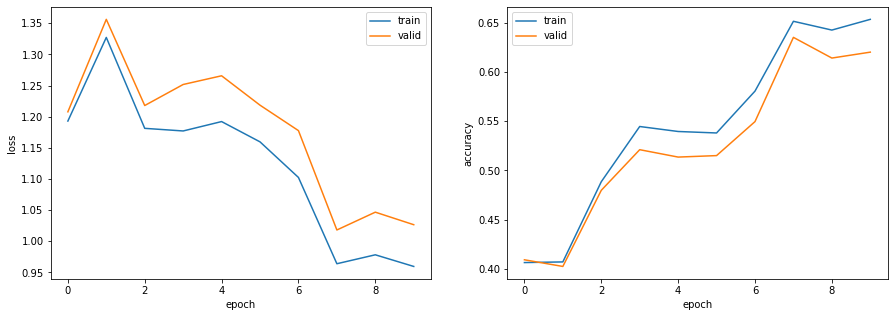

正解率（学習データ）：0.653
正解率（評価データ）：0.636


In [ ]:
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

visualize_logs(log)

# 正解率の算出
_, acc_train = cal_loss_acc(model, dataset_train)
_, acc_test = cal_loss_acc(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

###85.双方向RNN・多層化


In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)


epoch: 1, loss_train: 1.2001, accuracy_train: 0.4046, loss_valid: 1.2270, accuracy_valid: 0.4048, 14.3931sec
epoch: 2, loss_train: 1.1647, accuracy_train: 0.5091, loss_valid: 1.2041, accuracy_valid: 0.4858, 14.5560sec
epoch: 3, loss_train: 1.0786, accuracy_train: 0.5694, loss_valid: 1.1247, accuracy_valid: 0.5382, 14.5999sec
epoch: 4, loss_train: 1.0469, accuracy_train: 0.5926, loss_valid: 1.0868, accuracy_valid: 0.5675, 14.5658sec
epoch: 5, loss_train: 1.0196, accuracy_train: 0.6010, loss_valid: 1.0725, accuracy_valid: 0.5750, 14.5677sec
epoch: 6, loss_train: 0.9982, accuracy_train: 0.6170, loss_valid: 1.0405, accuracy_valid: 0.5892, 14.7315sec
epoch: 7, loss_train: 1.0352, accuracy_train: 0.5981, loss_valid: 1.1042, accuracy_valid: 0.5675, 14.6677sec
epoch: 8, loss_train: 0.9496, accuracy_train: 0.6385, loss_valid: 1.0076, accuracy_valid: 0.6109, 14.4734sec
epoch: 9, loss_train: 0.9512, accuracy_train: 0.6372, loss_valid: 1.0140, accuracy_valid: 0.6102, 14.6037sec
epoch: 10, loss_tra

In [ ]:
# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX))

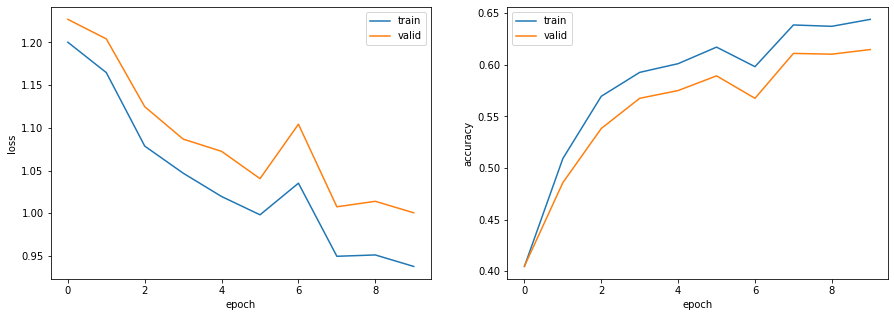

正解率（学習データ）：0.644
正解率（評価データ）：0.619


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = cal_loss_acc(model, dataset_train, device)
_, acc_test = cal_loss_acc(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

###86.畳み込みニューラルネットワーク (CNN)

In [ ]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2706, 0.2652, 0.2440, 0.2203]], grad_fn=<SoftmaxBackward>)
tensor([[0.2052, 0.2741, 0.2669, 0.2538]], grad_fn=<SoftmaxBackward>)
tensor([[0.2775, 0.2575, 0.2495, 0.2155]], grad_fn=<SoftmaxBackward>)
tensor([[0.3026, 0.2603, 0.2312, 0.2060]], grad_fn=<SoftmaxBackward>)
tensor([[0.2386, 0.2864, 0.2504, 0.2246]], grad_fn=<SoftmaxBackward>)
tensor([[0.2934, 0.2599, 0.2502, 0.1964]], grad_fn=<SoftmaxBackward>)
tensor([[0.2894, 0.2789, 0.2251, 0.2067]], grad_fn=<SoftmaxBackward>)
tensor([[0.2741, 0.2533, 0.2253, 0.2473]], grad_fn=<SoftmaxBackward>)
tensor([[0.2605, 0.2374, 0.2527, 0.2494]], grad_fn=<SoftmaxBackward>)
tensor([[0.2613, 0.2456, 0.2507, 0.2423]], grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


###87.確率的勾配降下法によるCNNの学習

In [ ]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX))

epoch: 1, loss_train: 1.0928, accuracy_train: 0.5348, loss_valid: 1.0980, accuracy_valid: 0.5352, 11.5095sec
epoch: 2, loss_train: 1.0160, accuracy_train: 0.6315, loss_valid: 1.0314, accuracy_valid: 0.5975, 11.1270sec
epoch: 3, loss_train: 0.9391, accuracy_train: 0.6713, loss_valid: 0.9669, accuracy_valid: 0.6462, 11.1096sec
epoch: 4, loss_train: 0.8752, accuracy_train: 0.6978, loss_valid: 0.9248, accuracy_valid: 0.6702, 11.1972sec
epoch: 5, loss_train: 0.8242, accuracy_train: 0.7137, loss_valid: 0.8812, accuracy_valid: 0.6867, 11.1406sec
epoch: 6, loss_train: 0.7908, accuracy_train: 0.7255, loss_valid: 0.8628, accuracy_valid: 0.6934, 11.1306sec
epoch: 7, loss_train: 0.7681, accuracy_train: 0.7324, loss_valid: 0.8466, accuracy_valid: 0.6979, 11.1048sec
epoch: 8, loss_train: 0.7550, accuracy_train: 0.7364, loss_valid: 0.8397, accuracy_valid: 0.7024, 11.1762sec
epoch: 9, loss_train: 0.7491, accuracy_train: 0.7385, loss_valid: 0.8356, accuracy_valid: 0.7024, 11.0478sec
epoch: 10, loss_tra

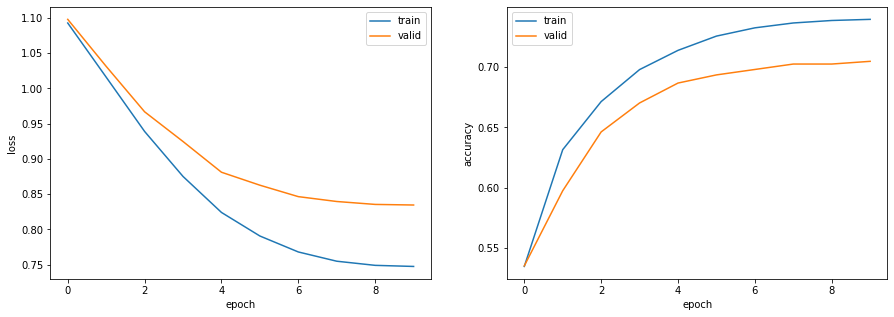

正解率（学習データ）：0.739
正解率（評価データ）：0.705


In [ ]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = cal_loss_acc(model, dataset_train, device)
_, acc_test = cal_loss_acc(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

###88.パラメータチューニング

###89.事前学習済み言語モデルからの転移学習

事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.2MB/s 
     |████████████████████████████████| 3.3MB 51.0MB/s 
     |████████████████████████████████| 901kB 53.5MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt


In [ ]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.y)

  def __getitem__(self, index): 
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.LongTensor(self.y[index])
    }

In [ ]:
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate=0.4, output_size=1):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    #self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, output_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    #out = self.fc(self.drop(out))
    return out

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-06-29 08:30:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip.1’

NewsAggregatorDatas 100%[===================>]  27.87M  91.1MB/s    in 0.3s    

2021-06-29 08:30:17 (91.1 MB/s) - ‘NewsAggregatorDataset.zip.1’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# データを読み込む
df = pd.read_csv('/content/newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 30
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer, max_len)

In [ ]:
for var in dataset_train[1]:
  print(f'{var}: {dataset_train[1][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 18921,  2595,  1011,  7922,  9466,  2006,  2149,  3446, 12143,
         2044, 14315,  2368,  7928,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
labels: tensor([1, 0, 0, 0])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#損失・正解率を計算
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      ids = data['ids']
      mask = data['mask']
      labels = data['labels']
      outputs = model(ids, mask)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [ ]:
def calculate_accuracy(model, dataset):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      ids = data['ids']
      mask = data['mask']
      labels = data['labels']
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()
  return correct / total

In [ ]:
#モデル学習
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):

  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    s_time = time.time()

    model.train()
    for data in dataloader_train:

      ids = data['ids']
      mask = data['mask']
      labels = data['labels']

      optimizer.zero_grad()
      #bug↓
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    #torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [ ]:
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

model = BERTClass(DROP_RATE, OUTPUT_SIZE)

criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

#device = 'cuda' if cuda.is_available() else 'cpu'

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#学習開始
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

In [ ]:
# 正解率を求める
print(f'train acc: {calculate_accuracy(model, dataset_train)}')
print(f'valid acc: {calculate_accuracy(model, dataset_valid)}')
print(f'test  acc: {calculate_accuracy(model, dataset_test)}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

---
kondo's code

In [ ]:
"""
89. 事前学習済み言語モデルからの転移学習Permalink
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．
"""

import pandas as pd
import numpy as np
import docutils.transforms.universal
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import logging

logging.basicConfig(level=logging.ERROR)

# データを読み込む
df = pd.read_csv('/content/newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "id_text": torch.LongTensor(ids),
            "mask": torch.LongTensor(mask),
            "labels": torch.Tensor(self.y[index])
        }

class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        #BERTの出力に合わせて768次元
        self.fc = torch.nn.Linear(768, output_size)

    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask)

        return out

def train_model(tr_data, va_data, model, criterion, optimizer, epochs=10, batch_size=1, collate_fn=None, device=None):

    model.to(device)

    #collate_fnはミニバッチ化する時にサイズを揃える時に使える。基本はtensorを返すだけ
    tr_l_data = DataLoader(tr_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    va_l_data = DataLoader(va_data, batch_size=1, shuffle=False)

    total_time = 0
    train_log = []
    valid_log = []
    for i in tqdm(range(epochs)):
        s_time = time.time()

        model.train()
        total_loss=0.0

        for j, X in enumerate(tr_l_data):
            optimizer.zero_grad()          #勾配の初期化
            #デバイスの指定
            inputs = X["id_text"].to(device)
            mask = X["mask"].to(device)
            labels = X["labels"].to(device)

            outputs = model.forward(inputs, mask)  #順伝播
            loss = criterion(outputs, labels)
            loss.backward()                     #逆伝播
            optimizer.step()               #重み更新

            total_loss += loss.item()
        train_loss = total_loss/(j+1)              #バッチ単位のロス

        model.eval()

        train_loss, train_acc = calculate_loss_acc(tr_data, model, criterion, device)
        valid_loss, valid_acc = calculate_loss_acc(va_data, model, criterion, device)
        train_log.append([train_loss, train_acc])
        valid_log.append([valid_loss, valid_acc])

        torch.save({"epoch": i+1, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}, f"checkpoinit{i+1}.pt")

        e_time = time.time()

        print(f"epoch: {i+1}, train loss: {train_loss:.5f}, train accuracy: {train_acc}, valid loss: {valid_loss}, valid accuracy: {valid_acc}, time: {(e_time-s_time):.5f}sec")

        total_time += e_time-s_time
        print(f"1エポックあたり{total_time/(i+1)}s\n")

    return {"train": train_log, "valid": valid_log}

def calculate_loss_acc(data, model, criterion, device=None):
    l_data = DataLoader(data, batch_size=1, shuffle=False)
    loss = 0
    total = 0
    cor = 0
    with torch.no_grad():
        for X in l_data:
            #デバイスの指定
            inputs = X["id_text"].to(device)
            mask = X["mask"].to(device)
            labels = X["labels"].to(device)

            outputs = model.forward(inputs, mask)
            loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(inputs)
            cor += (pred == labels).sum().item()
    return loss/len(l_data), cor/total

def plot(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log["train"]).T[0], label="train")
    ax[0].plot(np.array(log["valid"]).T[0], label="valid")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    ax[1].plot(np.array(log["train"]).T[1], label="train")
    ax[1].plot(np.array(log["valid"]).T[1], label="valid")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].legend()
    plt.show()

def result(train_dataset, test_dataset, model, criterion, device):
    _, train_acc = calculate_loss_acc(train_dataset, model, criterion, device)
    _, test_acc = calculate_loss_acc(test_dataset, model, criterion, device)
    print(f"train accuracy: {train_acc}")
    print(f"test accuracy: {test_acc}")


if __name__ == "__main__":
    DROP_RATE = 0.4
    OUTPUT_SIZE = 4
    BATCH_SIZE = 32
    NUM_EPOCHS = 4
    LEARNING_RATE = 0.00002

    # 正解ラベルのone-hot化
    y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
    y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
    y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

    # Datasetの作成
    max_len = 30
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer, max_len)
    dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer, max_len)
    dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer, max_len)
    """
    for var in dataset_train[0]:
        print(f"{var}: {dataset_train[0][var]}")
    #各単語をidに変換している
    ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,  4341,
            2039,  2005,  4369,  3204,  2004, 18730,  8980,   102,     0,     0])
    #0のところがpaddingされている部分
    mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
    #labelはone-hot
    labels: tensor([1., 0., 0., 0.])
    """

    model = BERTClass(DROP_RATE, OUTPUT_SIZE)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

    device = "cuda"

    log = train_model(dataset_train, dataset_valid, model, criterion, optimizer, NUM_EPOCHS, BATCH_SIZE, device=device)
    plot(log)
    result(dataset_train, dataset_valid, model, criterion, device)